<a href="https://colab.research.google.com/github/dmamur/elementsem/blob/main/notebooks/elembert_classification_baceV0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pickle,random
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding,Dense,Dropout,Input,Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import re, glob,os,sys
from collections import defaultdict
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

def bert_module(query, key, value, i, config):
    # Multi headed self-attention
    attention_output = layers.MultiHeadAttention(
        num_heads=config.NUM_HEAD,
        key_dim=config.EMBED_DIM // config.NUM_HEAD,
        name="encoder_{}/multiheadattention".format(i),
    )(query, key, value)
    attention_output = layers.Dropout(0.1, name="encoder_{}/att_dropout".format(i))(
        attention_output
    )
    attention_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}/att_layernormalization".format(i)
    )(query + attention_output)

    # Feed-forward layer
    ffn = tf.keras.Sequential(
        [
            layers.Dense(config.FF_DIM, activation="relu"),
            layers.Dense(config.EMBED_DIM),
        ],
        name="encoder_{}/ffn".format(i),
    )
    ffn_output = ffn(attention_output)
    ffn_output = layers.Dropout(0.1, name="encoder_{}/ffn_dropout".format(i))(
        ffn_output
    )
    sequence_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}/ffn_layernormalization".format(i)
    )(attention_output + ffn_output)
    return sequence_output


def get_pos_encoding_matrix(max_len, d_emb):
    pos_enc = np.array(
        [
            [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)]
            if pos != 0
            else np.zeros(d_emb)
            for pos in range(max_len)
        ]
    )
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])  # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])  # dim 2i+1
    return pos_enc

def create_elembert_model(inputs,config):
    word_embeddings = layers.Embedding(config.VOCAB_SIZE, config.EMBED_DIM, mask_zero=True,name="element_embdgs")(inputs)
    position_embeddings = layers.Embedding(input_dim=config.MAX_LEN,output_dim=config.EMBED_DIM,
                                           weights=[get_pos_encoding_matrix(config.MAX_LEN, config.EMBED_DIM)],
                                           name="position_embedding",)(tf.range(start=0, limit=config.MAX_LEN, delta=1))
    embeddings = word_embeddings + position_embeddings
    encoder_output = embeddings
    for i in range(config.NUM_LAYERS):
        encoder_output = bert_module(encoder_output, encoder_output, encoder_output, i, config)
    mlm_model = Model(inputs, encoder_output, name="masked_bert_model")

    return mlm_model


In [2]:
!pip install ase
!git clone https://github.com/dmamur/elementsem.git
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.6 MB/s eta 0:00:00
Cloning into 'elementsem'...
remote: Enumerating objects: 528, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 528 (delta 49), reused 1 (delta 1), pack-reused 444
Receiving objects: 100% (528/528), 91.77 MiB | 16.34 MiB/s, done.
Resolving deltas: 100% (265/265), done.
Updating files: 100% (259/259), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 8.9 MB/s eta 0:00:00


In [3]:
class Config:
    MAX_LEN = 256
    BATCH_SIZE = 128
    LR = 0.001
    VOCAB_SIZE = 128
    EMBED_DIM = 32
    NUM_HEAD = 2 # used in bert model
    FF_DIM = 32 # used in bert model
    NUM_LAYERS = 2
    MNAME = 'elembertR_'
    MVER = 'V0'
    DSPATH="/content/elementsem/data/"
    PREPATH="/content/elementsem/models/pretrained/"
    PATH="/content/elementsem/models/"
config = Config()
seed=12345
tf.random.set_seed(seed)
np.random.seed(seed)

In [15]:
! wget https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/bace.csv

--2023-09-03 10:01:30--  https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/bace.csv
Resolving deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)... 52.219.113.73, 52.219.112.57, 52.219.120.25, ...
Connecting to deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)|52.219.113.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3897767 (3.7M) [text/csv]
Saving to: ‘bace.csv’

bace.csv            100%[===================>]   3.72M  --.-KB/s    in 0.1s    

2023-09-03 10:01:31 (29.4 MB/s) - ‘bace.csv’ saved [3897767/3897767]



In [16]:
ds = 'bacr'
mname=config.PATH+config.MNAME+ds+'_%s_E_%s_H_%s_L_%s_bert.h5' % (config.MVER,config.EMBED_DIM,config.NUM_HEAD,config.NUM_LAYERS)

# Load vocabulary and types

In [25]:
from rdkit import Chem
import gzip
#df = pd.read_csv(config.DSPATH+ds+config.MVER+'_ds.csv')
#with gzip.open('clintox.csv.gz', 'rb') as file:
#    df = pd.read_csv(file)
df = pd.read_csv('bace.csv')
print(df.head())
types=[]
for i in df['mol']:
  m = Chem.MolFromSmiles(i)
  m2 = Chem.AddHs(m)
  types.append([atom.GetSymbol() for atom in m2.GetAtoms()])
labels  = to_categorical(np.asarray(df['Class']))
uniquelbls=len(np.unique(np.asarray(df['Class'])))

with open(config.PREPATH+'/el2id'+config.MVER+'.pkl', 'rb') as f:
    db = pickle.load(f)

element2id = db['el2id']
el2id = db['el2id']
config.VOCAB_SIZE = len(element2id)
print('vocabSize: ', config.VOCAB_SIZE)


                                                 mol     CID  Class  Model  \
0  O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2c...  BACE_1      1  Train   
1  Fc1cc(cc(F)c1)C[C@H](NC(=O)[C@@H](N1CC[C@](NC(...  BACE_2      1  Train   
2  S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...  BACE_3      1  Train   
3  S1(=O)(=O)C[C@@H](Cc2cc(O[C@H](COCC)C(F)(F)F)c...  BACE_4      1  Train   
4  S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...  BACE_5      1  Train   

      pIC50         MW   AlogP  HBA  HBD  RB  ...  PEOE6 (PEOE6)  \
0  9.154901  431.56979  4.4014    3    2   5  ...      53.205711   
1  8.853872  657.81073  2.6412    5    4  16  ...      73.817162   
2  8.698970  591.74091  2.5499    4    3  11  ...      70.365707   
3  8.698970  591.67828  3.1680    4    3  12  ...      56.657166   
4  8.698970  629.71283  3.5086    3    3  11  ...      78.945702   

   PEOE7 (PEOE7)  PEOE8 (PEOE8)  PEOE9 (PEOE9)  PEOE10 (PEOE10)  \
0      78.640335      226.85541      107.43491        3

In [21]:
len(types)

1513

# Convert types to integers

In [22]:
types0=[['[CLS]']+i+['[SEP]'] for i in types]
typesNumerical=[]
for i in types0:
    typesNumerical.append([element2id[j] for j in i])

x3 = tf.keras.preprocessing.sequence.pad_sequences(typesNumerical,dtype='int32',padding= 'post',truncating='post',maxlen=config.MAX_LEN)

#z = load_model(config.PREPATH+'/embert'+'_%s_E_%s_H_%s_L_%s_bert.h5' % (config.MVER,config.EMBED_DIM,config.NUM_HEAD,config.NUM_LAYERS),compile=False)
#z = load_model(config.PREPATH+'/elEmBERT'+'_%s_E_%s_H_%s_L_%s_bert.h5' % (config.MVER,config.EMBED_DIM,config.NUM_HEAD,config.NUM_LAYERS),compile=False)
#z.trainable = True

inputC = Input((config.MAX_LEN), dtype=tf.int32,name='types')
z = create_elembert_model(inputC,config)

e = Lambda(lambda x: x[:,0],name='clsTokenEmb')(z.output)
f = Dense(uniquelbls, activation="softmax",name='out_tox')(e)

model = Model(inputs=z.input, outputs=f)

#plot_model(model, show_shapes=True, show_layer_names=True,to_file=mname+".png")

optimizer = tf.keras.optimizers.Adam(learning_rate=config.LR)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[tf.keras.metrics.AUC()])

model.summary()

csv_logger = tf.keras.callbacks.CSVLogger(mname+"_log.csv", append=True)

checkpoint = tf.keras.callbacks.ModelCheckpoint(mname+".h5",verbose=2, mode='min',save_freq=1000,)

callbacks_list = [checkpoint,csv_logger]

print('dataLen: ',x3.shape,labels.shape)



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 types (InputLayer)             [(None, 256)]        0           []                               
                                                                                                  
 element_embdgs (Embedding)     (None, 256, 32)      3232        ['types[0][0]']                  
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 256, 32)     0           ['element_embdgs[0][0]']         
 da)                                                                                              
                                                                                                  
 encoder_0/multiheadattention (  (None, 256, 32)     4224        ['tf.__operators__.add[0][0]'

In [30]:
epochs=config.BATCH_SIZE*2

p = np.random.RandomState(seed=seed).permutation(len(labels))
n = len(p)

trainidx=p[:round(len(p)*0.8)]
validx = p[int(n*0.8):int(n*0.9)]
testidx = p[int(n*0.9):]

trainlog = model.fit(x=x3[trainidx], y=labels[trainidx],
                     validation_data = (x3[validx],labels[validx]),
                     verbose = 1,epochs = epochs, batch_size = config.BATCH_SIZE,callbacks = callbacks_list)

model.save(mname+".h5")

Epoch 1/256
10/10 [==============================] - 1s 55ms/step - loss: 0.4896 - auc: 0.8405 - val_loss: 0.5139 - val_auc: 0.8228
Epoch 2/256
10/10 [==============================] - 0s 43ms/step - loss: 0.4776 - auc: 0.8513 - val_loss: 0.5184 - val_auc: 0.8266
Epoch 3/256
10/10 [==============================] - 0s 44ms/step - loss: 0.4789 - auc: 0.8498 - val_loss: 0.5057 - val_auc: 0.8261
Epoch 4/256
10/10 [==============================] - 0s 44ms/step - loss: 0.4707 - auc: 0.8554 - val_loss: 0.5064 - val_auc: 0.8255
Epoch 5/256
10/10 [==============================] - 0s 34ms/step - loss: 0.4823 - auc: 0.8464 - val_loss: 0.5162 - val_auc: 0.8261
Epoch 6/256
10/10 [==============================] - 0s 33ms/step - loss: 0.4810 - auc: 0.8503 - val_loss: 0.5288 - val_auc: 0.8157
Epoch 7/256
10/10 [==============================] - 0s 33ms/step - loss: 0.4800 - auc: 0.8490 - val_loss: 0.5114 - val_auc: 0.8271
Epoch 8/256
10/10 [==============================] - 0s 35ms/step - loss: 0.

# Save results

In [31]:
extractorEmb = Model(inputs=model.inputs,outputs=model.get_layer(name="clsTokenEmb").output)

preds = model.predict(x3,batch_size = config.BATCH_SIZE)

dbresults={}
dbresults['pred_emb'] = extractorEmb.predict(x3,batch_size = config.BATCH_SIZE)
dbresults['pred_cls'] = preds
dbresults['y_cls'] = labels
dbresults['formula'] = df['mol']
dbresults['ids'] = df['CID']
dbresults['types'] = types
dbresults['trainidx'] = trainidx
dbresults['testidx'] = validx
dbresults['validx'] = validx

with open(mname+'_results.pkl', 'wb') as f:
    pickle.dump(dbresults, f)

12/12 [==============================] - 1s 15ms/step


# Postprocessing

In [32]:
from matplotlib import cm
from sklearn.manifold import TSNE
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
tsne = TSNE(n_components=2, verbose=0, random_state=123)
z = tsne.fit_transform(dbresults['pred_emb'])

In [33]:
dfr = pd.DataFrame()
dfr["y"] = np.asarray(dbresults['y_cls'].argmax(axis=-1))
dfr["yp"] = np.asarray(dbresults['pred_cls'].argmax(axis=-1))
dfr["tSNE1"] = z[:,0]
dfr["tSNE2"] = z[:,1]

binary tf-acc: 0.8869795
/content/elementsem/models/elembertR_bacr_V0_E_32_H_2_L_2_bert.h5  AUC: 0.9471967


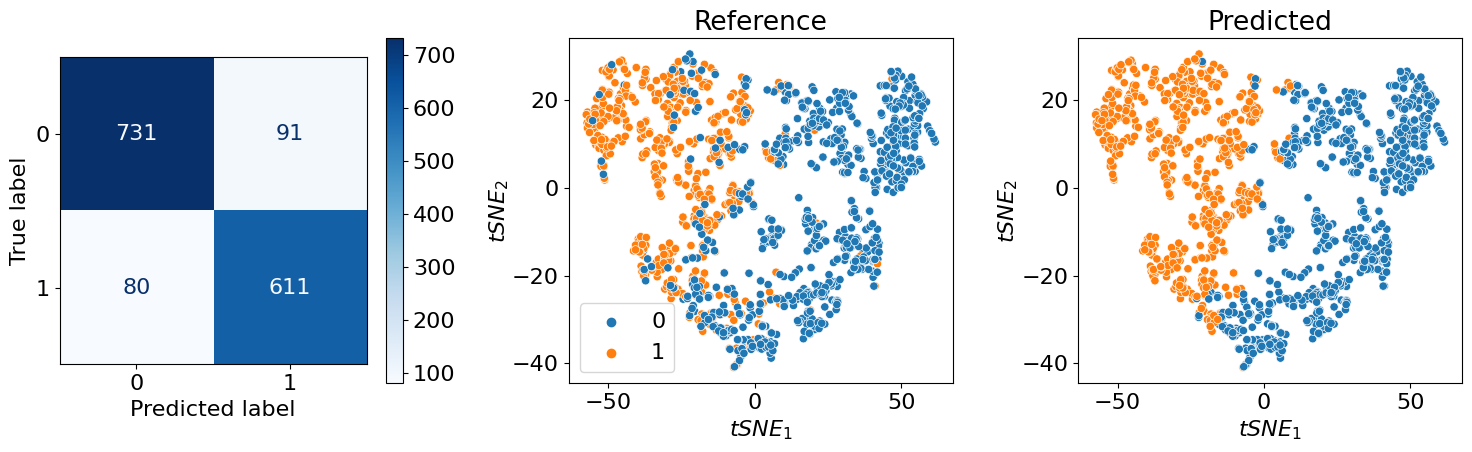

<Figure size 640x480 with 0 Axes>

In [34]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(1, 3, figsize=(15, 4.8))
y_pclasses = dbresults['pred_cls'].argmax(axis=-1)
y_classes = dbresults['y_cls'].argmax(axis=-1)
print('binary tf-acc:',tf.keras.metrics.binary_accuracy(y_classes, y_pclasses, threshold=0.5).numpy())
m = tf.keras.metrics.AUC()
m.update_state(dbresults['y_cls'], dbresults['pred_cls'])
print(mname, ' AUC:',m.result().numpy())
confusion_matrix = metrics.confusion_matrix(y_classes, y_pclasses)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
                                            #display_labels=['False','True'])
cm_display.plot(ax=axes[0],cmap=plt.cm.Blues)

sns.scatterplot(ax=axes[1],x="tSNE1", y="tSNE2", hue=dfr.y.tolist(),data=dfr)#.set(title=title+" data T-SNE projection")
axes[1].set_xlabel('$tSNE_1$')
axes[1].set_ylabel('$tSNE_2$',labelpad=1)
axes[1].set_title('Reference')
#axes[1].legend('',frameon=False)
sns.scatterplot(ax=axes[2],x="tSNE1", y="tSNE2", hue=dfr.yp.tolist(),data=dfr)#.set(title=title+" data T-SNE projection")
axes[2].set_title('Predicted')
axes[2].set_xlabel('$tSNE_1$')
axes[2].set_ylabel('$tSNE_2$',labelpad=1)
axes[2].legend('',frameon=False)
fig.tight_layout()
plt.show()
plt.savefig(mname+'_tsnePaper.jpg',format='jpg',dpi=800,bbox_inches = "tight")